# Set 2 - Figure 4

## Importing Libraries

In [1]:
# Data Management
import numpy as np
import pandas as pd
from pandas import DataFrame 
from kneed import KneeLocator


# Data Visualization
import matplotlib.pyplot as plt
import plotly.express as px

# Machine Learning
from sklearn.manifold import MDS
from sklearn.cluster import KMeans

### Ecopy function distance() from https://github.com/Auerilas/ecopy/blob/master/ecopy/ordination/distance.py

In [2]:
def distance(x, method='euclidean', transform="1", breakNA=True):
    '''
    Docstring for function ecopy.distance
    ========================
    Computes a dissimilarity matrix from a given matrix,
        where distances are calculated among rows. Multiple
        similarity/dissimilarity metrics are possible, and it is
        up to the user to choose the correct one. In the case of similarity
        metrics, dissimilarity is calculated as 1-D unless otherwise specified.
        See Legendre and Legendre for details on coefficients.

    For binary coefficients, A is # shared similarities, B and C are #'s of
        differences, and D is # of shared absences

    Most quantitative (i.e. non-binary) metrics will work with binary data.
        In fact, some methods are redundant. For example, bray = sorensen 
        when bray is passed a binary data frame. However, both methods are 
        provided here for simplicity and clarity

    Use
    ----
    distance(x, method='euclidean', transform="1", breakNA=True)

    Returns a numpy.ndarray square, symmetric matrix

    Parameters
    ----------
    x:  numpy array or pandas dataframe with observations as rows
        and descriptors as columns
    method: a method used for calculating similarities
        euclidean: calculates euclidean distance between rows (default)
                sqrt(d1^2 + d2^2 + ... + dn^2)
        gow_euclidean: calculates euclidean distance between rows, removing NAs
                sqrt(delta*(x1-x2)**2/sum(delta))
                where delta = 1 if both observations present, 0 otherwise
        chord: calculates the chord distance between rows
                this is the euclidean distance of normalized vectors
        manhattan: manhattan distance between rows
                sum(abs(xik - xjk)) over all k
        meanChar: Czekanowski's mean character difference
                1/M*(sum(abs(xik - xjk))) over all k
                where M is the number of columns
        whittaker: Whittaker's index of association
                0.5*sum(abs(x1-x2)) where x1 and x2 are
                first standardized by vector totals (x1/sum(x1))
        canberra: Canberra metric
                sum(abs(xik-xjk) / (xik+xjk))*1/M 
                where M is the number of species present at both sites
        hellinger: Hellinger distance
                same as the chord but square-root transformed first
        mod_gower: modified Gower distance
                same as meanChar except M is the number of 
                columns that are not double zero
         simple: simple matching of binary data (SIMILARITY)
                (A + D)/(A + B + C + D)
        rogers: Rogers and Tanimoto coefficient for binary data (SIMILARITY)
                (A + D) / (A + 2B + 2C + D)
        sokal: Sokal and Sneath coefficient for binary data (SIMILARITY)
                (2A + 2D)/(2A + B + C + 2D)
        jaccard: Jaccard's coefficient for binary data (SIMILARITY)
                A/(A + B + C)
        sorensen: Sorensen's coefficient for binary data (SIMILARITY)
                2A/(2A + B + C)
        kulczynski: Kulczynski's coefficient (SIMILARITY)
                0.5*(sum(min(xi,xj))/sum(xi) + sum(min(xi,xj))/sum(xj))
        ochiai: Ochiai's coefficient for binary data (SIMILARITY)
                A/sqrt((A + B)(A + C))
        bray: Bray-Curtis coefficient (SIMILARITY)
                2*sum(min(xi, xj))/(sum(xi) + sum(xj))
        gower: Gower assymetrical coefficient (SIMILARITY)
                (1-(abs(xik - xjk))/(max(xk)-min(xk)))*1/M
                where k is species and M is the number of columns.
                The denominator is the maximum of species k minus the min of 
                species k in the entire matrix. Note that double zero columns
                are excluded here.
        NOTE: All metrics denoted as SIMILARITY are transformed to dissimilarity using
            D = 1 - Similarity
    transform: how should dissimilarities be transformed.
        "1": D (default)
        "sqrt": sqrt(D)
    breakNA: should the process halt if the matrix contains any NAs?
        if False, then NA's undergo pairwise deletion during distance calculation,
        such that when calculating the distance between two rows, if any
        species is missing from a row, that species is removed from both rows

    Example
    --------
    import ecopy as ep
    varespec = ep.load_data('varespec')
    distance(varespec, method='euclidean')

    # for binary data
    varespec[varespec>0] = 1
    distance(varespec, method='jaccard)
    '''
    listofmethods =['euclidean', 'gow_euclidean', 'simple', 'rogers', 'sokal', 'jaccard', 'sorensen', 'kulczynski', 'bray', 'gower', 'chord', 'manhattan', 'meanChar', 'whittaker', 'canberra', 'hellinger', 'mod_gower', 'ochiai']
    if not isinstance(breakNA, bool):
        msg = 'removaNA argument must be boolean'
        raise ValueError(msg)
    if method not in listofmethods:
        msg = 'method argument {0!s} is not an accepted metric'.format(method)
        raise ValueError(msg)
    if not isinstance(x, (DataFrame, np.ndarray)):
        msg = 'x argument must be a numpy array or pandas dataframe'
        raise ValueError(msg)
    if isinstance(x, DataFrame):
        if (x.dtypes == 'object').any():
            msg = 'DataFrame can only contain numeric values'
            raise ValueError(msg)
        x = np.array(x)
    if breakNA:
        if np.isnan(np.sum(x)):
            msg = 'Matrix contains NA values'
            raise ValueError(msg)
    if np.min(np.sum(x, axis=1))==0:
        msg = 'One row is entirely zeros, distance calculations will be meaningless'
        raise ValueError(msg)
    if transform not in ['1', 'sqrt']:
        msg = 'transform argument must be "1" or "sqrt"'
        raise ValueError(msg)
    if method in ['simple', 'rogers', 'sokal', 'jaccard', 'sorensen', 'ochiai']:
        if np.any((x != 0) & (x != 1)):
            msg = 'For method {0}, data must be binary'.format(method)
            raise ValueError(msg)
    x = x.astype('float')
    if method == 'euclidean':
        distMat = np.zeros((x.shape[0], x.shape[0]))
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,~np.isnan(x[i,:])]
                x2 = x[j,~np.isnan(x[i,:])]
                x1 = x1[~np.isnan(x2)]
                x2 = x2[~np.isnan(x2)]
                distMat[i,j] = eucFunc(x1, x2, transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)
    if method == 'gow_euclidean':
        distMat = np.zeros((x.shape[0], x.shape[0]))
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,:]
                x2 = x[j,:]
                delta = ~(np.isnan(x1) + np.isnan(x2))
                delta = delta.astype(int)
                x1[np.isnan(x1)] = -999
                x2[np.isnan(x2)] = -999
                distMat[i,j] = eucGow(x1, x2, delta, transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)
    if method == 'simple':
        distMat = np.zeros((x.shape[0], x.shape[0]))
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,~np.isnan(x[i,:])]
                x2 = x[j,~np.isnan(x[i,:])]
                x1 = x1[~np.isnan(x2)]
                x2 = x2[~np.isnan(x2)]
                A, B, C, D = matchMat(x1, x2)
                distMat[i,j] = simpleSim(A, B, C, D, transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)
    if method == 'rogers':
        distMat = np.zeros((x.shape[0], x.shape[0]))
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,~np.isnan(x[i,:])]
                x2 = x[j,~np.isnan(x[i,:])]
                x1 = x1[~np.isnan(x2)]
                x2 = x2[~np.isnan(x2)]
                A, B, C, D = matchMat(x1, x2)
                distMat[i,j] = rogerSim(A, B, C, D, transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)
    if method == 'sokal':
        distMat = np.zeros((x.shape[0], x.shape[0]))
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,~np.isnan(x[i,:])]
                x2 = x[j,~np.isnan(x[i,:])]
                x1 = x1[~np.isnan(x2)]
                x2 = x2[~np.isnan(x2)]
                A, B, C, D = matchMat(x1, x2)
                distMat[i,j] = sokalSim(A, B, C, D, transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)
    if method == 'jaccard':
        distMat = np.zeros((x.shape[0], x.shape[0]))
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,~np.isnan(x[i,:])]
                x2 = x[j,~np.isnan(x[i,:])]
                x1 = x1[~np.isnan(x2)]
                x2 = x2[~np.isnan(x2)]
                A, B, C, D = matchMat(x1, x2)
                distMat[i,j] = jaccardSim(A, B, C, D, transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)
    if method == 'sorensen':
        distMat = np.zeros((x.shape[0], x.shape[0]))
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,~np.isnan(x[i,:])]
                x2 = x[j,~np.isnan(x[i,:])]
                x1 = x1[~np.isnan(x2)]
                x2 = x2[~np.isnan(x2)]
                A, B, C, D = matchMat(x1, x2)
                distMat[i,j] = sorenSim(A, B, C, D, transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)
    if method == 'kulczynski':
        if (x<0).any():
            msg = 'Distances are meaningless for negative numbers'
            raise ValueError(msg)
        distMat = np.zeros((x.shape[0], x.shape[0]))
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,~np.isnan(x[i,:])]
                x2 = x[j,~np.isnan(x[i,:])]
                x1 = x1[~np.isnan(x2)]
                x2 = x2[~np.isnan(x2)]
                distMat[i,j] = kulSim(x1, x2, transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)
    if method == 'bray':
        if (x<0).any():
            msg = 'Distances are meaningless for negative numbers'
            raise ValueError(msg)
        distMat = np.zeros((x.shape[0], x.shape[0]))
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,~np.isnan(x[i,:])]
                x2 = x[j,~np.isnan(x[i,:])]
                x1 = x1[~np.isnan(x2)]
                x2 = x2[~np.isnan(x2)]
                distMat[i,j] = braySim(x1, x2, transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)
    if method == 'gower':
        if (x<0).any():
            msg = 'Distances are meaningless for negative numbers'
            raise ValueError(msg)
        distMat = np.zeros((x.shape[0], x.shape[0]))
        R = np.apply_along_axis(lambda z: np.max(z) - np.min(z), 0, x)
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,~np.isnan(x[i,:])]
                R = R[~np.isnan(x[i,:])]
                x2 = x[j,~np.isnan(x[i,:])]
                x1 = x1[~np.isnan(x2)]
                x2 = x2[~np.isnan(x2)]
                R = R[~np.isnan(x2)]
                distMat[i,j] = gowerSim(x1, x2, R, transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)
    if method == 'chord':
        distMat = np.zeros((x.shape[0], x.shape[0]))
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,~np.isnan(x[i,:])]
                x2 = x[j,~np.isnan(x[i,:])]
                x1 = x1[~np.isnan(x2)]
                x2 = x2[~np.isnan(x2)]
                distMat[i,j] = chordDis(x1, x2, transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)
    if method == 'manhattan':
        distMat = np.zeros((x.shape[0], x.shape[0]))
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,~np.isnan(x[i,:])]
                x2 = x[j,~np.isnan(x[i,:])]
                x1 = x1[~np.isnan(x2)]
                x2 = x2[~np.isnan(x2)]
                distMat[i,j] = manDist(x1, x2, transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)
    if method == 'meanChar':
        distMat = np.zeros((x.shape[0], x.shape[0]))
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,~np.isnan(x[i,:])]
                x2 = x[j,~np.isnan(x[i,:])]
                x1 = x1[~np.isnan(x2)]
                x2 = x2[~np.isnan(x2)]
                distMat[i,j] = charDist(x1, x2, transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)
    if method == 'whittaker':
        if (x<0).any():
            msg = 'Distances are meaningless for negative numbers'
            raise ValueError(msg)
        distMat = np.zeros((x.shape[0], x.shape[0]))
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,~np.isnan(x[i,:])]
                x2 = x[j,~np.isnan(x[i,:])]
                x1 = x1[~np.isnan(x2)]
                x2 = x2[~np.isnan(x2)]
                distMat[i,j] = whitDist(x1, x2, transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)
    if method == 'canberra':
        if (x<0).any():
            msg = 'Distances are meaningless for negative numbers'
            raise ValueError(msg)
        distMat = np.zeros((x.shape[0], x.shape[0]))
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,~np.isnan(x[i,:])]
                x2 = x[j,~np.isnan(x[i,:])]
                x1 = x1[~np.isnan(x2)]
                x2 = x2[~np.isnan(x2)]
                distMat[i,j] = canDist(x1, x2, transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)
    if method == 'hellinger':
        distMat = np.zeros((x.shape[0], x.shape[0]))
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,~np.isnan(x[i,:])]
                x2 = x[j,~np.isnan(x[i,:])]
                x1 = x1[~np.isnan(x2)]
                x2 = x2[~np.isnan(x2)]
                distMat[i,j] = chordDis(np.sqrt(x1), np.sqrt(x2), transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)
    if method == 'mod_gower':
        if (x<0).any():
            msg = 'Distances are meaningless for negative numbers'
            raise ValueError(msg)
        distMat = np.zeros((x.shape[0], x.shape[0]))
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,~np.isnan(x[i,:])]
                x2 = x[j,~np.isnan(x[i,:])]
                x1 = x1[~np.isnan(x2)]
                x2 = x2[~np.isnan(x2)]
                distMat[i,j] = m_gowDist(x1, x2, transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)
    if method == 'ochiai':
        distMat = np.zeros((x.shape[0], x.shape[0]))
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,~np.isnan(x[i,:])]
                x2 = x[j,~np.isnan(x[i,:])]
                x1 = x1[~np.isnan(x2)]
                x2 = x2[~np.isnan(x2)]
                A, B, C, D = matchMat(x1, x2)
                distMat[i,j] = ochiaiSim(A, B, C, D, transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)

def eucFunc(d1, d2, t):
    d = d1-d2
    eucD = np.sqrt(np.sum(np.square(d)))
    if t == "1":
        return eucD
    if t == "sqrt":
        return np.sqrt(eucD)

def eucGow(d1, d2, Delta, t):
    d = d1-d2
    eucGow = np.sqrt(np.sum(Delta*d**2)/Delta.sum())
    if t == "1":
        return eucGow
    if t == "sqrt":
        return np.sqrt(eucGow)

def matchMat(d1, d2):
    A = float(np.sum((d1 == 1) & (d2 == 1)))
    B = float(np.sum((d1 == 1) & (d2 == 0)))
    C = float(np.sum((d1 == 0) & (d2 == 1)))
    D = float(np.sum((d1 == 0) & (d2 == 0)))
    return A, B, C, D

def simpleSim(A, B, C, D, t):
    S = (A + D) / (A + B + C + D)
    if t == "1":
        return 1 - S
    if t == "sqrt":
        return np.sqrt(1 - S)

def rogerSim(A, B, C ,D, t):
    S = (A + D) / (A + 2*B + 2*C + D)
    if t == "1":
        return 1 - S
    if t == "sqrt":
        return np.sqrt(1 - S)

def sokalSim(A, B, C, D, t):
    S = (2*A + 2*D) / (2*A + B + C + 2*D)
    if t == "1":
        return 1 - S
    if t == "sqrt":
        return np.sqrt(1 - S)

def jaccardSim(A, B, C, D, t):
    S = A/(A + B + C)
    if t == "1":
        return 1 - S
    if t == "sqrt":
        return np.sqrt(1 - S)

def sorenSim(A, B, C, D, t):
    S = 2*A/(2*A + B + C)
    if t == "1":
        return 1 - S
    if t == "sqrt":
        return np.sqrt(1 - S)

def kulSim(d1, d2, t):
    A = np.sum(d1)
    B = np.sum(d2)
    W = np.sum(np.minimum(d1, d2))
    S = 0.5*(W/A + W/B)
    if t == "1":
        return 1 - S
    if t == "sqrt":
        return np.sqrt(1 - S)
        
def braySim(d1, d2, t):
    A = np.sum(d1)
    B = np.sum(d2)
    W = np.sum(np.minimum(d1, d2))
    S = (2*W)/(A + B)
    if t == "1":
        return 1 - S
    if t == "sqrt":
        return np.sqrt(1 - S)

def gowerSim(d1, d2, R, t):
    diffs = 1 - (np.abs(d1-d2)/R)
    isabs = d1+d2 ==0
    S = np.sum(~isabs*diffs)/np.sum(~isabs)
    if t == "1":
        return 1 - S
    if t == "sqrt":
        return np.sqrt(1 - S)

def chordDis(d1, d2, t):
    norm1 = 1/(np.sqrt(np.sum(d1**2))) * d1
    norm2 = 1/(np.sqrt(np.sum(d2**2))) * d2
    d = norm1-norm2
    chordD = np.sqrt(np.sum(np.square(d)))
    if t == "1":
        return chordD
    if t == "sqrt":
        return np.sqrt(chordD)

def manDist(d1, d2, t):
    manD = np.sum(np.abs(d1 - d2))
    if t == "1":
        return manD
    if t == "sqrt":
        return np.sqrt(manD)

def charDist(d1, d2, t):
    charD = 1./len(d1) * np.sum(np.abs(d1 - d2))
    if t == "1":
        return charD
    if t == "sqrt":
        return np.sqrt(charD)

def whitDist(d1, d2, t):
    d1 = d1/np.sum(d1)
    d2 = d2/np.sum(d2)
    whitD = 0.5*sum(np.abs(d1-d2))
    if t == "1":
        return whitD
    if t == "sqrt":
        return np.sqrt(whitD)

def canDist(d1, d2, t):
    isabs = d1+d2==0
    d1 = d1[~isabs]
    d2 = d2[~isabs]
    canD = np.sum(np.abs(d1-d2)/(d1+d2)) * 1./np.sum(~isabs)
    if t == "1":
        return canD
    if t == "sqrt":
        return np.sqrt(canD)

def m_gowDist(d1, d2, t):
    isabs = d1+d2==0
    charD = 1./np.sum(~isabs) * np.sum(np.abs(d1 - d2))
    if t == "1":
        return charD
    if t == "sqrt":
        return np.sqrt(charD)
        
def ochiaiSim(A, B, C, D, t):
    S = A/np.sqrt((A + B) * (A + C))
    if t == "1":
        return 1 - S
    if t == "sqrt":
        return np.sqrt(1 - S)

## Epi1

### Cleaning Metadata 

#### Curating Metadata

In [3]:
f1_ec1 = pd.read_csv('files/epi1/PDS000140119.22.tsv', sep = '\t')
f2_ec1 = pd.read_csv('files/epi1/12838_metadata_biosample.csv')
f3_ec1 = f2_ec1[['sra_id', 'biosample_id']]
f3_ec1 = f3_ec1.rename(columns = {'biosample_id':'BioSample',
                          'sra_id':'id'})

d1_ec1 = pd.merge(f1_ec1, f3_ec1, how = 'inner', on = 'BioSample')
d2_ec1 = d1_ec1[['id', 'Location', 'Isolation source']]

da2_ec1 = d2_ec1[['id', 'Location']]
da2_ec1 = da2_ec1.set_index('id')
da2_ec1 = da2_ec1['Location'].str.split(':', expand = True).add_prefix('name_')
da2_ec1 = da2_ec1.rename(columns = {'name_0':'Country'})
da2_ec1 = da2_ec1.drop('name_1', axis = 1)

d3_ec1 = pd.merge(d2_ec1, da2_ec1, how = 'inner', on = 'id')

def replace_country_ec1(x):
    if x == 'USA':                     # 7260
        return 'United States'
    elif x == 'United Kingdom':        # 2057
        return 'United Kingdom'
    else:
        return 'Others'
    
d3_ec1['Country'] = d3_ec1['Country'].apply(replace_country_ec1) 
d3_ec1['source'] = d3_ec1['Isolation source'].str.lower() 

def replace_host_ec1(x):
    if x == 'swine':
        return 'Swine'
    elif x == 'sus scrofa':
        return 'Swine'
    elif x == 'sus domesticus':
        return 'Swine'
    elif x == 'pork':
        return 'Swine'
    elif x == 'porcine':
        return 'Swine'
    elif x == 'pig':
        return 'Swine'
    elif x == 'hogs':
        return 'Swine'
    elif x == 'pig at slaughter':
        return 'Swine'
    elif x == 'animal-swine-market swine':
        return 'Swine'
    elif x == 'pork chop':
        return 'Swine'
    elif x == 'intestine (sus scrofa)':
        return 'Swine'
    elif x == 'animal-swine-sow':
        return 'Swine'
    elif x == 'feces (sus scrofa)':
        return 'Swine'
    elif x == 'product-raw-ground, comminuted or otherwise nonintact-pork':
        return 'Swine'
    elif x == 'product-raw-intact-pork':
        return 'Swine'
    elif x == 'raw intact pork':
        return 'Swine'
    elif x == 'pooled tissue (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'porcine tissue pool':
        return 'Swine'
    elif x == 'porcine liver':
        return 'Swine'
    elif x == 'intestine (sus domesticus)':
        return 'Swine'
    elif x == 'sus scrofa domesticus, culture plate':
        return 'Swine'
    elif x == 'pooled ileum (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'intestine (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'small intestine (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'ileum (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'colon (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'swine, livestock, pig':
        return 'Swine'
    elif x == 'animal-swine-market swine (cecal)':
        return 'Swine'
    elif x == 'lung (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'colon(sus scrofa domesticus)':
        return 'Swine'
    elif x == 'pig meat':
        return 'Swine'
    elif x == 'swine bacterial strain':
        return 'Swine'
    elif x == 'ground pork':
        return 'Swine'
    elif x == 'feces (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'animal-swine-sow (cecal)':
        return 'Swine'
    elif x == 'spleen (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'liver (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'pork chops':
        return 'Swine'
    elif x == 'colon (sus scrofa)':
        return 'Swine'
    elif x == 'roasted pig':
        return 'Swine'
    elif x == 'animal-swine-roaster swine':
        return 'Swine'
    elif x == 'tissue (sus scrofa)':
        return 'Swine'
    elif x == 'feces swine':
        return 'Swine'
    elif x == 'pig intestine (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'pig spleen (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'pig colon (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'pulled pork':
        return 'Swine'
    elif x == 'slaughterhouse pig':
        return 'Swine'
    elif x == 'tissue pool porcine':
        return 'Swine'
    elif x == 'porcine lung':
        return 'Swine'
    elif x == 'porcine intestine (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'porcine lung (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'swine feces':
        return 'Swine'
    elif x == 'boneless pork':
        return 'Swine'
    elif x == 'porcine pooled tissue':
        return 'Swine'
    elif x == 'lymph (sus scrofa)':
        return 'Swine'
    elif x == 'boiled pork with mustard greens':
        return 'Swine'
    elif x == 'raw liver from pork':
        return 'Swine'
    elif x == 'feces porcine':
        return 'Swine'
    elif x == 'porcine colon':
        return 'Swine'
    elif x == 'liver porcine':
        return 'Swine'
    elif x == 'porcine intestine':
        return 'Swine'
    elif x == 'porcine colon (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'raw ground comminuted nonintact pork':
        return 'Swine'
    elif x == 'swine carcass':
        return 'Swine'
    elif x == 'porcine mesenteric lymph node (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'porcine liver (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'pork meat':
        return 'Swine'
    elif x == 'porcine fecal swab (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'porcine peritoneal swab (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'porcine intesinte pooled (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'porcine intestinal swab (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'porcine feces':
        return 'Swine'
    elif x == 'raw pork':
        return 'Swine'
    elif x == 'pork sausage':
        return 'Swine'
    elif x == 'porcine fecal swab':
        return 'Swine'
    elif x == 'swine colon':
        return 'Swine'
    elif x == 'porcine pool intestines':
        return 'Swine'
    elif x == 'intestine (porcine)':
        return 'Swine'
    elif x == 'porcine feces (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'porcine lymph node (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'pork liver':
        return 'Swine'
    elif x == 'pork kidney':
        return 'Swine'
    elif x == 'pork intestine':
        return 'Swine'
    elif x == 'pork fat':
        return 'Swine'
    elif x == 'feces (sus domesticus)':
        return 'Swine'
    elif x == 'porcine pleural (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'feces (sus scrofa domesticus )':
        return 'Swine'
    elif x == 'pork & cabbage dumplings':
        return 'Swine'
    elif x == 'porcine oral fluid (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'rectal swab (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'caecum (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'tissue pool (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'jejunum porcine':
        return 'Swine'
    elif x == 'mesenteric nodes (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'caecum content (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'pig feces':
        return 'Swine'
    elif x == 'farmed pig':
        return 'Swine'
    elif x == 'swine, food, pork':
        return 'Swine'
    elif x == 'rectum (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'spleen porcine':
        return 'Swine'
    elif x == 'stomach porcine':
        return 'Swine'
    elif x == 'pig mechanically separated meat':
        return 'Swine'
    elif x == 'intestine(sus scrofa domesticus)':
        return 'Swine'
    elif x == 'rectal swab(sus scrofa domesticus)':
        return 'Swine'
    elif x == 'lung(sus scrofa domesticus)':
        return 'Swine'
    elif x == 'liver(sus scrofa domesticus)':
        return 'Swine'
    elif x == 'pork carcasses':
        return 'Swine'
    
    elif x == 'human':
        return 'Human'
    elif x == 'human bacterial strain':
        return 'Human'
    elif x == 'human, blood culture':
        return 'Human'
    elif x == 'human, faeces':
        return 'Human'
    elif x == 'human, other':
        return 'Human'
    elif x == 'human, stool':
        return 'Human'
    elif x == 'human, urine':
        return 'Human'
    elif x == 'stool':
        return 'Human'
    elif x == 'clinical sample':
        return 'Human'
    elif x == 'blood':
        return 'Human'
    
    elif x == 'turkey':
        return 'Poultry'
    elif x == 'chicken':
        return 'Poultry'
    elif x == 'comminuted turkey':
        return 'Poultry'
    elif x == 'hen bacterial strain':
        return 'Poultry'
    elif x == 'chicken bacterial strain':
        return 'Poultry'
    elif x == 'feces (gallus gallus domesticus)':
        return 'Poultry'
    elif x == 'animal-turkey-young turkey':
        return 'Poultry'
    elif x == 'poultry':
        return 'Poultry'
    elif x == 'raw intact chicken':
        return 'Poultry'
    elif x == 'ground turkey':
        return 'Poultry'
    elif x == 'nrte (not-ready-to-eat) comminuted poultry exploratory sampling - turkeys':
        return 'Poultry'
    elif x == 'animal-turkey-young turkey (cecal)':
        return 'Poultry'
    elif x == 'ground chicken':
        return 'Poultry'
    elif x == 'animal-turkey-turkey carcass sponge':
        return 'Poultry'
    elif x == 'chicken - young chicken carcass rinse (pre-evisceration)':
        return 'Poultry'
    elif x == 'turkey fluff':
        return 'Poultry'
    elif x == 'turkey carcass sponge':
        return 'Poultry'
    elif x == 'ground component turkey':
        return 'Poultry'
    elif x == 'ground component chicken':
        return 'Poultry'
    elif x == 'comminuted poultry turkey':
        return 'Poultry'
    elif x == 'turkey intestine (meleagris gallopavo)':
        return 'Poultry'
    elif x == 'chicken caecum pre-harvest poultry':
        return 'Poultry'
    elif x == 'chicken carcass':
        return 'Poultry'
    elif x == 'comminuted chicken':
        return 'Poultry'
    elif x == 'animal-chicken-young chicken':
        return 'Poultry'
    elif x == 'chicken meat':
        return 'Poultry'
    elif x == 'poultry meat':
        return 'Poultry'
    elif x == 'finished ground turkey':
        return 'Poultry'
    elif x == 'retail ground turkey':
        return 'Poultry'
    elif x == 'chicken breasts':
        return 'Poultry'
    elif x == 'turkey intestine':
        return 'Poultry'
    elif x == 'poultry manure':
        return 'Poultry'
    elif x == 'chicken breast':
        return 'Poultry'
    elif x == 'chicken whole - cut in lab':
        return 'Poultry'
    elif x == 'turkey fluff (meleagris gallopavo)':
        return 'Poultry'
    elif x == 'chicken whole-cut in lab':
        return 'Poultry'
    elif x == 'turkey faeces':
        return 'Poultry'
    
    elif x == 'product-raw-intact-beef':
        return 'Bovine'
    elif x == 'animal-cattle-beef cow':
        return 'Bovine'
    elif x == 'animal-cattle-dairy cow':
        return 'Bovine'
    elif x == 'animal-cattle-dairy cow (cecal)':
        return 'Bovine'
    elif x == 'animal-calf-bob veal (cecal)':
        return 'Bovine'
    elif x == 'animal-cattle-steer (cecal)':
        return 'Bovine'
    elif x == 'intestine (bos taurus)':
        return 'Bovine'
    elif x == 'feces (bos taurus)':
        return 'Bovine'
    elif x == 'cattle':
        return 'Bovine'
    elif x == 'bovine bacterial strain':
        return 'Bovine'
    elif x == 'buffalo bacterial strain':
        return 'Bovine'
    elif x == 'calf bacterial strain':
        return 'Bovine'
    elif x == 'beef':
        return 'Bovine'
    elif x == 'comminuted beef':
        return 'Bovine'
    elif x == 'tissue pool (bos taurus)':
        return 'Bovine'
    elif x == 'calf feces':
        return 'Bovine'
    elif x == 'jersey calf':
        return 'Bovine'
    elif x == 'calf lymph node':
        return 'Bovine'
    elif x == 'calf small intestine':
        return 'Bovine'
    elif x == 'animal-calf-bob veal':
        return 'Bovine'
    elif x == 'rte product-beef corndog':
        return 'Bovine'
    elif x == 'bovine brain (bos taurus)':
        return 'Bovine'
    elif x == 'animal-cattle-steer':
        return 'Bovine'
    elif x == 'pooled tissue (bos taurus)':
        return 'Bovine'
    elif x == 'pooled tissue (bos taurus)':
        return 'Bovine'
    elif x == 'boneless beef':
        return 'Bovine'
    elif x == 'raw intact beef':
        return 'Bovine'
    elif x == 'bovine fecal swab (bos taurus)':
        return 'Bovine'
    elif x == 'bovine lung (bos taurus)':
        return 'Bovine'
    elif x == 'bovine lymph node (bos taurus)':
        return 'Bovine'
    elif x == 'bovine intestine':
        return 'Bovine'
    elif x == 'biological fluid or and tissue bovine':
        return 'Bovine'
    elif x == 'intestines (bovine)':
        return 'Bovine'
    elif x == 'feces bovine':
        return 'Bovine'
    elif x == 'bovine mesenteric lymph node':
        return 'Bovine'
    elif x == 'ground beef':
        return 'Bovine'
    elif x == 'bovine':
        return 'Bovine'
    elif x == 'bovine manure':
        return 'Bovine'
    elif x == 'liver (bos taurus)':
        return 'Bovine'
    elif x == 'food [ground beef]':
        return 'Bovine'

    else:
        return 'Others'
    
d3_ec1['Source'] = d3_ec1['source'].apply(replace_host_ec1)

md_ec1 = d3_ec1[['id', 'Country', 'Source']]

## Read files 
st_ec1 = pd.read_csv('files/epi1/mlst_output.csv')        # 12230
cgmlst_ec1 = pd.read_csv('files/epi1/sistr_output.csv')   # 12230

## Clean up ST data
st_ec1 = st_ec1.rename(columns = {'FILE':'id'})
st1_ec1 = st_ec1[['id', 'ST']]

def replace_st_ec1(x):
    if x == '34':          # 11273
        return 'ST34'
    else:
        return 'Others'
    
st1_ec1['ST'] = st1_ec1['ST'].apply(replace_st_ec1)

## Clean up cgMLST data
cgmlst_ec1 = cgmlst_ec1[['cgmlst_ST', 'genome', 'serovar_antigen']]
cgmlst_ec1 = cgmlst_ec1.rename(columns = {'cgmlst_ST':'cgMLST',
                                  'genome':'id',
                                  'serovar_antigen':'serovar'})
cgmlst_ec1 = cgmlst_ec1[['id', 'cgMLST', 'serovar']]

def replace_serovar_ec1(x):
    if x == 'I 1,4,[5],12:i:-':
        return 'I 1,4,[5],12:i:-'
    else:
        return 'Others'
    
cgmlst_ec1['Serovar'] = cgmlst_ec1['serovar'].apply(replace_serovar_ec1)
cgmlst_ec1 = cgmlst_ec1.drop(['serovar', 'cgMLST'], axis = 1)

md1_ec1 = pd.merge(st1_ec1, cgmlst_ec1, how = 'inner', on = 'id')
md1_ec1 = md1_ec1[['id', 'Serovar', 'ST']]

md2_ec1 = pd.merge(md1_ec1, md_ec1, how = 'inner', on =  'id')

## Apply filters (before filters 11656, after 1797)

## Keep only ST34
md2_ec1 = md2_ec1.loc[md2_ec1['ST'] == 'ST34']

## Drop ST34 if not monophasic
md2_ec1 = md2_ec1.loc[~(md2_ec1['Serovar'] == 'Others')]

## Keep only UK
md2_ec1 = md2_ec1.loc[md2_ec1['Country'] == 'United Kingdom']

## Keep only Human
md2_ec1 = md2_ec1.loc[md2_ec1['Source'] == 'Human']

C:\Users\steph\AppData\Local\Temp\ipykernel_15220\1717366361.py:445: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  st1_ec1['ST'] = st1_ec1['ST'].apply(replace_st_ec1)


#### Curating Rtab File

In [4]:
rtab1_ec1 = pd.read_csv('files/epi1/gene_presence_absence.Rtab', sep = '\t')
rtab1_ec1 = rtab1_ec1.set_index('Gene')
rtab1_ec1 = rtab1_ec1.transpose()

rtab2_ec1 = rtab1_ec1.reset_index()
rtab2_ec1 = rtab2_ec1.rename(columns = {'index':'id'})

## Extract unique ids for Rtab curation
unique_id_ec1 = md2_ec1['id']

rtab_ec1 = pd.merge(unique_id_ec1, rtab2_ec1, how = 'inner', on =  'id')
rtab_ec1 = rtab_ec1.set_index('id')

### Final Metadata

In [5]:
## ignore all hypothetical genes (genes that start with group_)
j1_ec1 = rtab_ec1.loc[:,~rtab_ec1.columns.str.startswith('group_')]
j2_ec1 = j1_ec1.sum()

## Find shell genes (15 - 95%)
j3_ec1 = (j2_ec1/j1_ec1.shape[0]) * 100
j3_ec1 = j3_ec1.rename('prop')
j3_ec1 = j3_ec1.reset_index()

sg_ec1 = j3_ec1.loc[(j3_ec1['prop'] >= 15) & (j3_ec1['prop'] < 95)]
sg_ec1 = sg_ec1.rename(columns = {'index':'Gene'})
sg_ec1 = sg_ec1.set_index('Gene')

j4_ec1 = j1_ec1.transpose()
j4_ec1 = j4_ec1.reset_index()
j4_ec1 = j4_ec1.rename(columns = {'index':'Gene'})
j5_ec1 = pd.merge(j4_ec1, sg_ec1, how = 'inner', on = 'Gene')
j5_ec1 = j5_ec1.drop('prop', axis = 1)
j5_ec1 = j5_ec1.set_index('Gene')
j5_ec1 = j5_ec1.transpose()
j5_ec1 = j5_ec1.reset_index()
j5_ec1 = j5_ec1.rename(columns = {'index':'id'})

coln_ec1 = j5_ec1.columns
first_ec1 = coln_ec1[1] # ybfF
last_ec1 = coln_ec1[-1] # ccmH

## Filter out genes with counts higher than 1
j6_ec1 = pd.melt(j5_ec1, id_vars = ['id'], value_vars = list(coln_ec1[1:-1]))
j6_ec1 = j6_ec1.loc[j6_ec1['value'] <= 1]

## Spread the data
j7_ec1 = j6_ec1.pivot(index = ['id'], columns = ['Gene'])
j7_ec1 = j7_ec1.droplevel(0, axis = 1)

metadata_epi1 = pd.merge(md2_ec1, j7_ec1, how = 'inner', on = 'id')
# metadata_epi1 # 1797 rows

### Jaccard Cluster Calculation

In [6]:
md_epi1 = metadata_epi1.drop(['Serovar', 'ST', 'Country', 'Source'], axis = 1).set_index('id')

## Machine Learning Algorithm for Jaccard Method
np.random.seed(4490)

j8_epi1 = distance(md_epi1, method = 'jaccard', breakNA = False)
j9_epi1 = MDS(n_components = 3, dissimilarity = 'precomputed')
j10_epi1 = j9_epi1.fit_transform(j8_epi1)

ja10_epi1 = md_epi1
ja10_epi1 = ja10_epi1.reset_index()
ja10_epi1 = ja10_epi1['id']

j10_epi1 = pd.DataFrame(j10_epi1)

jac_epi1 = pd.concat([ja10_epi1, j10_epi1], axis = 1)
jac_epi1 = jac_epi1.set_index('id')
jac_epi1 = jac_epi1.rename(columns = {0:'PC1',
                                1:'PC2',
                                2:'PC3'})

## kmeans clustering analysis
np.random.seed(123)
kmax_epi1 = 11
cluster_data_epi1 = jac_epi1
wss_epi1 = []

for i in range(1, kmax_epi1):
    kmeans_epi1 = KMeans(n_clusters = i, n_init = 50,max_iter = 1000)
    kmeans_epi1.fit(cluster_data_epi1)
    wss_epi1.append(kmeans_epi1.inertia_)

wss2_epi1 = pd.DataFrame(wss_epi1)
k_id_epi1 = list(range(1, kmax_epi1))
wss2_epi1['id'] = k_id_epi1
wss2_epi1 = wss2_epi1.rename(columns = {0:'WSS'})
wss2_epi1['Clusters'] = wss2_epi1['id']
wss2_epi1 = wss2_epi1.set_index('id')

## Elbow method for finding the optimal number of clusters
kl_epi1 = KneeLocator(wss2_epi1['Clusters'], wss2_epi1['WSS'], curve="convex", direction="decreasing")
elbow_epi1 = kl_epi1.elbow

k_final_epi1 = KMeans(n_clusters = elbow_epi1)
clust_epi1 = k_final_epi1.fit(cluster_data_epi1)

clust1_epi1 = clust_epi1.labels_
clust2_epi1 = cluster_data_epi1
clust2_epi1['Jaccard'] = clust1_epi1 + 1 
clust2_epi1 = clust2_epi1.reset_index()

jac_dist_epi1 = clust2_epi1[['id', 'Jaccard', 'PC1', 'PC2', 'PC3']]
jac_dist_epi1['Jaccard'] = jac_dist_epi1['Jaccard'].astype('category')

## Epi2

### Cleaning Metadata 

#### Curating Metadata

In [7]:
f1_ec2 = pd.read_csv('files/epi2/PDS000142542.2.tsv', sep = '\t')
f2_ec2 = pd.read_csv('files/epi2/sample.ids.sra')
f2_ec2 = f2_ec2.rename(columns = {'Run':'id'})

d1_ec2 = pd.merge(f1_ec2, f2_ec2, how = 'inner', on = 'BioSample')
d2_ec2 = d1_ec2[['id', 'Location', 'Isolation source']]

da2_ec2 = d2_ec2[['id', 'Location']]
da2_ec2 = da2_ec2.set_index('id')
da2_ec2 = da2_ec2['Location'].str.split(':', expand = True).add_prefix('name_')
da2_ec2 = da2_ec2.rename(columns = {'name_0':'Country'})
da2_ec2 = da2_ec2.drop('name_1', axis = 1)

d3_ec2 = pd.merge(d2_ec2, da2_ec2, how = 'inner', on = 'id')

def replace_country_ec2(x):
    if x == 'United Kingdom':
        return 'United Kingdom'
    elif x == 'England, Lancashire':
        return 'United Kingdom'
    elif x == 'England, Nottinghamshire':
        return 'United Kingdom'
    elif x == 'USA':
        return 'United States'
    else:
        return 'Others'
    
d3_ec2['Country'] = d3_ec2['Country'].apply(replace_country_ec2)

d4_ec2 = pd.read_csv('files/epi2/3515_metadata_for_cleaning.csv')
d4_ec2['source'] = d4_ec2['Isolation source'].str.lower() 

def replace_host_ec2(x):
    if x == 'swine':
        return 'Swine'
    elif x == 'sus scrofa':
        return 'Swine'
    elif x == 'sus domesticus':
        return 'Swine'
    elif x == 'pork':
        return 'Swine'
    elif x == 'porcine':
        return 'Swine'
    elif x == 'pig':
        return 'Swine'
    elif x == 'hogs':
        return 'Swine'
    elif x == 'pig at slaughter':
        return 'Swine'
    elif x == 'animal-swine-market swine':
        return 'Swine'
    elif x == 'pork chop':
        return 'Swine'
    elif x == 'intestine (sus scrofa)':
        return 'Swine'
    elif x == 'animal-swine-sow':
        return 'Swine'
    elif x == 'feces (sus scrofa)':
        return 'Swine'
    elif x == 'product-raw-ground, comminuted or otherwise nonintact-pork':
        return 'Swine'
    elif x == 'product-raw-intact-pork':
        return 'Swine'
    elif x == 'raw intact pork':
        return 'Swine'
    elif x == 'pooled tissue (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'porcine tissue pool':
        return 'Swine'
    elif x == 'porcine liver':
        return 'Swine'
    elif x == 'intestine (sus domesticus)':
        return 'Swine'
    elif x == 'sus scrofa domesticus, culture plate':
        return 'Swine'
    elif x == 'pooled ileum (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'intestine (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'small intestine (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'ileum (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'colon (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'swine, livestock, pig':
        return 'Swine'
    elif x == 'animal-swine-market swine (cecal)':
        return 'Swine'
    elif x == 'lung (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'colon(sus scrofa domesticus)':
        return 'Swine'
    elif x == 'pig meat':
        return 'Swine'
    elif x == 'swine bacterial strain':
        return 'Swine'

    elif x == 'turkey':
        return 'Poultry'
    elif x == 'chicken':
        return 'Poultry'
    elif x == 'comminuted turkey':
        return 'Poultry'
    elif x == 'hen bacterial strain':
        return 'Poultry'
    elif x == 'chicken bacterial strain':
        return 'Poultry'
    elif x == 'feces (gallus gallus domesticus)':
        return 'Poultry'
    
    elif x == 'product-raw-intact-beef':
        return 'Bovine'
    elif x == 'animal-cattle-beef cow':
        return 'Bovine'
    elif x == 'animal-cattle-dairy cow':
        return 'Bovine'
    elif x == 'animal-cattle-dairy cow (cecal)':
        return 'Bovine'
    elif x == 'animal-calf-bob veal (cecal)':
        return 'Bovine'
    elif x == 'animal-cattle-steer (cecal)':
        return 'Bovine'
    elif x == 'intestine (bos taurus)':
        return 'Bovine'
    elif x == 'feces (bos taurus)':
        return 'Bovine'
    elif x == 'cattle':
        return 'Bovine'
    elif x == 'bovine bacterial strain':
        return 'Bovine'
    elif x == 'buffalo bacterial strain':
        return 'Bovine'
    elif x == 'calf bacterial strain':
        return 'Bovine'
    elif x == 'beef':
        return 'Bovine'
    elif x == 'comminuted beef':
        return 'Bovine'
    elif x == 'tissue pool (bos taurus)':
        return 'Bovine'
    
    elif x == 'human':
        return 'Human'
    elif x == 'human bacterial strain':
        return 'Human'
    elif x == 'human, blood culture':
        return 'Human'
    elif x == 'human, faeces':
        return 'Human'
    elif x == 'human, other':
        return 'Human'
    elif x == 'human, stool':
        return 'Human'
    elif x == 'human, urine':
        return 'Human'
    elif x == 'stool':
        return 'Human'
    elif x == 'clinical sample':
        return 'Human'
    else:
        return 'Others'
    
d4_ec2['Source'] = d4_ec2['source'].apply(replace_host_ec2)
da4_ec2 = d4_ec2[['id', 'Source']]

d5_ec2 = pd.merge(d3_ec2, da4_ec2, how = 'inner', on = 'id')
md_ec2 = d5_ec2[['id', 'Country', 'Source']]

## Read necessary files
st_ec2 = pd.read_csv('files/epi2/mlst_output.csv')
cgmlst_ec2 = pd.read_csv('files/epi2/sistr_output.csv')

## Clean up ST data
st_ec2 = st_ec2.rename(columns = {'FILE':'id'})
st1_ec2 = st_ec2[['id', 'ST']]

def replace_st_ec2(x):
    if x == '34':        # 3351
        return 'ST34'
    else:
        return 'Others'
    
st1_ec2['ST'] = st1_ec2['ST'].apply(replace_st_ec2)

## Clean up cgMLST data
cgmlst_ec2 = cgmlst_ec2[['genome', 'serovar_antigen']]
cgmlst_ec2 = cgmlst_ec2.reset_index()
cgmlst_ec2 = cgmlst_ec2.rename(columns = {'index':'cgMLST',
                                  'genome':'id',
                                  'serovar_antigen':'serovar'})
cgmlst_ec2 = cgmlst_ec2[['id', 'cgMLST', 'serovar']]

def replace_serovar_ec2(x):
    if x == 'I 1,4,[5],12:i:-':
        return 'I 1,4,[5],12:i:-'
    else:
        return 'Others'
    
cgmlst_ec2['Serovar'] = cgmlst_ec2['serovar'].apply(replace_serovar_ec2)
cgmlst_ec2 = cgmlst_ec2.drop(['serovar', 'cgMLST'], axis = 1)

md1_ec2 = pd.merge(st1_ec2, cgmlst_ec2, how = 'inner', on = 'id')
md1_ec2 = md1_ec2[['id', 'Serovar', 'ST']]

md2_ec2 = pd.merge(md1_ec2, md_ec2, how = 'inner', on =  'id')

## Apply filters (before filters 3391, after 1247)

## Keep only ST34
md2_ec2 = md2_ec2.loc[md2_ec2['ST'] == 'ST34']

## Drop ST34 if not monophasic
md2_ec2 = md2_ec2.loc[~(md2_ec2['Serovar'] == 'Others')]

## Keep only UK
md2_ec2 = md2_ec2.loc[md2_ec2['Country'] == 'United Kingdom']

## Keep only Human
md2_ec2 = md2_ec2.loc[md2_ec2['Source'] == 'Human']

C:\Users\steph\AppData\Local\Temp\ipykernel_15220\1569795950.py:184: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  st1_ec2['ST'] = st1_ec2['ST'].apply(replace_st_ec2)


#### Curating Rtab File

In [8]:
rtab1_ec2 = pd.read_csv('files/epi2/gene_presence_absence.Rtab', sep = '\t')
rtab1_ec2 = rtab1_ec2.set_index('Gene')
rtab1_ec2 = rtab1_ec2.transpose()

rtab2_ec2 = rtab1_ec2.reset_index()
rtab2_ec2 = rtab2_ec2.rename(columns = {'index':'id'})

## Extract unique ids for Rtab curation
unique_id_ec2 = md2_ec2['id']

rtab_ec2 = pd.merge(unique_id_ec2, rtab2_ec2, how = 'inner', on =  'id')
rtab_ec2 = rtab_ec2.set_index('id')

#### Final Metadata

In [9]:
## ignore all hypothetical genes (genes that start with group_)
j1_ec2 = rtab_ec2.loc[:,~rtab_ec2.columns.str.startswith('group_')]
j2_ec2 = j1_ec2.sum()

## Find shell genes (15 - 95%)
j3_ec2 = (j2_ec2/j1_ec2.shape[0]) * 100
j3_ec2 = j3_ec2.rename('prop')
j3_ec2 = j3_ec2.reset_index()

sg_ec2 = j3_ec2.loc[(j3_ec2['prop'] >= 15) & (j3_ec2['prop'] < 95)]
sg_ec2 = sg_ec2.rename(columns = {'index':'Gene'})
sg_ec2 = sg_ec2.set_index('Gene')

j4_ec2 = j1_ec2.transpose()
j4_ec2 = j4_ec2.reset_index()
j4_ec2 = j4_ec2.rename(columns = {'index':'Gene'})
j5_ec2 = pd.merge(j4_ec2, sg_ec2, how = 'inner', on = 'Gene')
j5_ec2 = j5_ec2.drop('prop', axis = 1)
j5_ec2 = j5_ec2.set_index('Gene')
j5_ec2 = j5_ec2.transpose()
j5_ec2 = j5_ec2.reset_index()
j5_ec2 = j5_ec2.rename(columns = {'index':'id'})

coln_ec2 = j5_ec2.columns
first_ec2 = coln_ec2[1] # srlB_2
last_ec2 = coln_ec2[-1] # yfdG_2

## Filter out genes with counts higher than 1
j6_ec2 = pd.melt(j5_ec2, id_vars = ['id'], value_vars = list(coln_ec2[1:-1]))
j6_ec2 = j6_ec2.loc[j6_ec2['value'] <= 1]

## Spread the data
j7_ec2 = j6_ec2.pivot(index = ['id'], columns = ['Gene'])
j7_ec2 = j7_ec2.droplevel(0, axis = 1)

metadata_epi2 = pd.merge(md2_ec2, j7_ec2, how = 'inner', on = 'id')
# metadata_epi2 # 1247 rows

#### Jaccard Cluster Calculation

In [10]:
md_epi2 = metadata_epi2.drop(['Serovar', 'ST', 'Country', 'Source'], axis = 1).set_index('id')

## Machine Learning Algorithm for Jaccard Method
np.random.seed(4490)

j8_epi2 = distance(md_epi2, method = 'jaccard', breakNA = False)
j9_epi2 = MDS(n_components = 3, dissimilarity = 'precomputed')
j10_epi2 = j9_epi2.fit_transform(j8_epi2)

ja10_epi2 = md_epi2
ja10_epi2 = ja10_epi2.reset_index()
ja10_epi2 = ja10_epi2['id']

j10_epi2 = pd.DataFrame(j10_epi2)

jac_epi2 = pd.concat([ja10_epi2, j10_epi2], axis = 1)
jac_epi2 = jac_epi2.set_index('id')
jac_epi2 = jac_epi2.rename(columns = {0:'PC1',
                                1:'PC2',
                                2:'PC3'})

## kmeans clustering analysis
np.random.seed(123)
kmax_epi2 = 11
cluster_data_epi2 = jac_epi2
wss_epi2 = []

for i in range(1, kmax_epi2):
    kmeans_epi2 = KMeans(n_clusters = i, n_init = 50,max_iter = 1000)
    kmeans_epi2.fit(cluster_data_epi2)
    wss_epi2.append(kmeans_epi2.inertia_)

wss2_epi2 = pd.DataFrame(wss_epi2)
k_id_epi2 = list(range(1, kmax_epi2))
wss2_epi2['id'] = k_id_epi2
wss2_epi2 = wss2_epi2.rename(columns = {0:'WSS'})
wss2_epi2['Clusters'] = wss2_epi2['id']
wss2_epi2 = wss2_epi2.set_index('id')

## Elbow method for finding the optimal number of clusters
kl_epi2 = KneeLocator(wss2_epi2['Clusters'], wss2_epi2['WSS'], curve="convex", direction="decreasing")
elbow_epi2 = kl_epi2.elbow

k_final_epi2 = KMeans(n_clusters = elbow_epi2)
clust_epi2 = k_final_epi2.fit(cluster_data_epi2)

clust1_epi2 = clust_epi2.labels_
clust2_epi2 = cluster_data_epi2
clust2_epi2['Jaccard'] = clust1_epi2 + 1 
clust2_epi2 = clust2_epi2.reset_index()

jac_dist_epi2 = clust2_epi2[['id', 'Jaccard', 'PC1', 'PC2', 'PC3']]
jac_dist_epi2['Jaccard'] = jac_dist_epi2['Jaccard'].astype('category')

## Figures

### Epi1

#### Elbow Plot

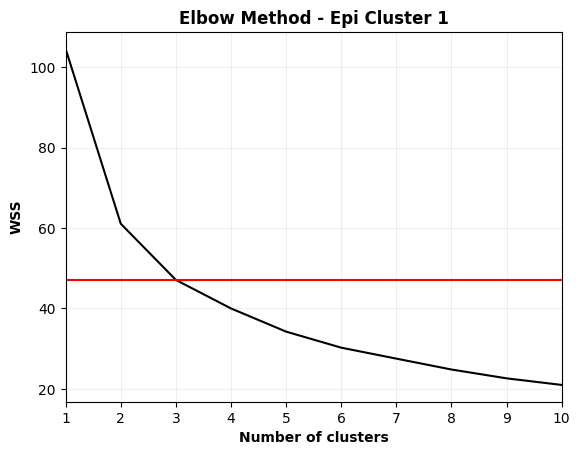

In [11]:
plt.plot(wss2_epi1['Clusters'], wss2_epi1['WSS'], color = 'k')
plt.title('Elbow Method - Epi Cluster 1', fontweight = 'bold')
plt.xlabel('Number of clusters', fontweight = 'bold')
plt.ylabel('WSS', fontweight = 'bold')

plt.xticks(wss2_epi1['Clusters'])
plt.xlim(1, 10)

plt.axhline(y = wss2_epi1.loc[elbow_epi1, 'WSS'], color = 'r', linestyle = '-')

plt.grid(alpha = 0.2)

#### Kmeans Jaccard Clusters

In [12]:
jac_dist_epi1 = px.scatter_3d(jac_dist_epi1, x = 'PC1', y = 'PC2', z = 'PC3', color = 'Jaccard',
                             category_orders = {'Jaccard': [1, 2, 3, 4]})
jac_dist_epi1.show()

### Epi2

#### Elbow Plot

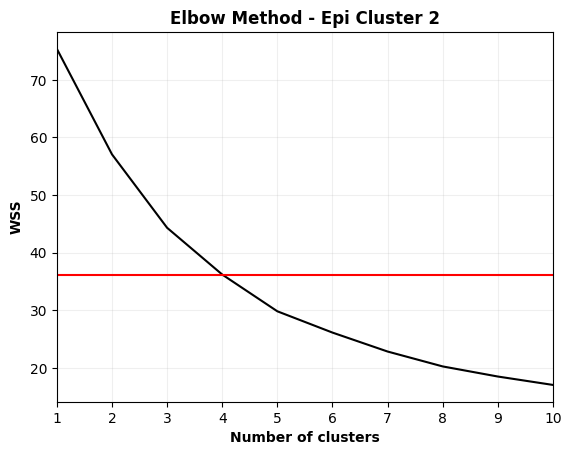

In [13]:
plt.plot(wss2_epi2['Clusters'], wss2_epi2['WSS'], color = 'k')
plt.title('Elbow Method - Epi Cluster 2', fontweight = 'bold')
plt.xlabel('Number of clusters', fontweight = 'bold')
plt.ylabel('WSS', fontweight = 'bold')

plt.xticks(wss2_epi2['Clusters'])
plt.xlim(1, 10)

plt.axhline(y = wss2_epi2.loc[elbow_epi2, 'WSS'], color = 'r', linestyle = '-')

plt.grid(alpha = 0.2)

#### Kmeans Jaccard Clusters

In [14]:
jac_dist_epi2 = px.scatter_3d(jac_dist_epi2, x = 'PC1', y = 'PC2', z = 'PC3', color = 'Jaccard',
                             category_orders = {'Jaccard': [1, 2, 3, 4]})
jac_dist_epi2.show()